<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> Laboratorio Nº1 </h2>
    <h2> 19 de agosto del 2016</h2>
    <h4> Roberto Felipe Fuentes Zenteno - 201173037-2 - roberto.fuentes@alumnos.usm.cl</h4>
</center>



# Tabla de Contenidos
* [Introducción](#intro)
* [Desarrollo y análisis de resultados](#des)
    - [Pregunta 1](#pregunta1)
    - [Pregunta 2](#pregunta2)
    - [Pregunta 3](#pregunta3)
    - [Pregunta 4](#pregunta4)
* [Conclusiones](#con)
* [Referencias](#ref)

<div id='intro' />
# Introducción


En esta experiencia analizaremos la convergencia de distintos metodos para obtener el valor propio dominante de una matriz simetrica definida positiva, y veremos cual de estos metodos es mejor y cual peor, ademas de analizar como funcionan estos algoritmos y estimar sus complejidades.

<div id='des' />
# Desarrollo y análisis de resultados


In [2]:
%matplotlib inline

import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
from numpy.linalg import norm, solve, linalg
import scipy
import scipy.linalg

<div id='pregunta1' />
## Pregunta 1

Aqui definiremos la funcion que creara matrices con valores aleatorios, ademas los 4 algoritmos pedidos para la realización del laboratorio.

In [3]:
def crear_matriz(n):
#Seteamos la semilla en 0 para obtener siempre la misma matriz aleatoria de nxn
    np.random.seed(0)
    #Creamos una matriz y la llenamos con valores aleatorios
    B = []
    for i in range(n):
        tmp = []
        for j in range(n):
            tmp.append(np.random.rand())
        B.append(tmp)
    #Hacemos la decomposicion QR = B
    Q, R = linalg.qr(B)
    #Creamos una matriz diagonal con n valores propios
    lam = []
    for i in range(n):
        lam.append(1.0 / (1.0 + (1+i)))
    Lambda = np.diag(lam)
    A = np.dot(Q,np.dot(Lambda,Q.transpose()))
    return A

#Algoritmo Power Iteration
def power_iteration(A, x, k):
    for j in range(k):
        u = x/norm(x)
        x = np.dot(A, u)
    lam = np.dot(u, x)
    u = x/norm(x)
    return (lam, u) 

#Algoritmo Inverse Power Iteration
def inverse_power_iteration(A, x, s, k):
    As = A - s*np.eye(*A.shape)
    for j in range(k):
        u = x/norm(x)
        x = solve(As, u)
    lam = np.dot(u.T, x)
    u = x/norm(x)
    return (1./lam+s, u)

#Algoritmo Raylight power iteration
def rqi(A, x, k):
    for j in range(k):
        u = x/norm(x)
        lam = np.dot(u.T, np.dot(A, u))
        try:
            x = solve(A -lam*np.eye(*A.shape), u)
        except numpy.linalg.linalg.LinAlgError:
            break
    u = x/norm(x)
    lam = float(np.dot(u.T, np.dot(A, u)))
    return (lam, u)

#Algoritmo Unshifted QR
def unshiftedqr(A,k):
    Q_0 = np.eye(A.shape[0])
    Qbarra = Q_0.copy()
    R_0 = A.copy()
    for i in range(k):
        Q_0,R_0 = np.linalg.qr( np.dot(R_0,Q_0) )
        Qbarra = np.dot(Qbarra,Q_0)
    lam = np.diag( np.dot(R_0,Q_0) )
    return lam,Qbarra,lam[0]

<div id='pregunta2' />
## Pregunta 2

Como se vio en la pregunta 1), tanto Inverse Power Iteration como Rayleigh quotient Iteration utilizaron el $solver$ de phyton para resolver el sistema de ecuaciones lineales que nos entregara la inversa. Si observamos la documentación mostrada en la seccion de "Referencias" mas abajo, observamos que esta funcion es computada usando la rutina LAPACK _gesv (la cual esta documentada tambien en la seccion de referencias), pudiendo ver que la complejidad para resolver un sistema de ecuación lineal usando esta rutina es de $\frac{2n^{3}}{3}$.

Teniendo esto presente, procedemos a ver la complejidad de los algoritmos:

### Power Iteration
Observamos que la operación mas costosa esta es la multiplicación $matriz-vector$ dentro del $for$, haciendo que el numero de O.E (operaciones elementales) de esa multiplicación sea de $2n-1$. Como esto itera $k$ veces, el numero de operaciones total en $k$ ciclos sería de $k\cdot (2n-1)$. Por lo tanto la complejidad de este algoritmo es de $2nk$.

### Inverse Power Iteration 
Claramente la operacion mas costosa del algoritmo es resolver el sistema de ecuaciones lineales. Como mencionamos anteriormente, la complejidad es de $\frac{2n^{3}}{3}$. Como esto está dentro del ciclo $for$ de $k$ iteraciones, el numero de operaciones total en $k$ ciclos seria de $\frac{2kn^{3}}{3}$, por lo que la complejidad del algoritmo es de $\frac{2kn^{3}}{3}$.

### Rayleigh Quotient Iteration
Identificamos la operacion mas costosa, que al igual que Inverse Power Iteration es el $solver$,el cual nos resuelve el sistema de ecuaciones lineales, con complejidad de $\frac{2n^{3}}{3}$. Como esta dentro del ciclo de $k$ iteraciones, el numero de operaciones total en $k$ ciclos seria de $\frac{2kn^{3}}{3}$ al igual que en Inverse Power Interation, dandonos como resultado una complejidad final del algoritmo $\frac{2kn^{3}}{3}$.

### Unshifted QR
Aqui la operacion mas costosa de resolver es separar la matriz en 2 matrices mediante el algoritmo de $QR$. Sabemos que la complejidad de la descomposición $QR$ es de $n^{3}$, y ya que esta dentro del ciclo $for$ de $k$ iteraciones, la complejidad final del algoritmo es de $kn^{3}$.

Luego de esto, calcularemos el tiempo que demora cada iteracion en cada algoritmo, repitiendo el experimento 5 veces utilizando 500 iteraciones para cada metodo.

In [4]:
#En esta celda se inicializan los vectores inciales para cada algoritmo y las respectivas matrices.
y1 = np.ones(10) 
M1 = crear_matriz(10)
y2 = np.ones(100)
M2 = crear_matriz(100)
y3 = np.ones(1000)
M3 = crear_matriz(1000)
y4 = np.ones(2000)
M4 = crear_matriz(2000)

In [5]:
def tiempo_promedio(metodo):
    resultado = [0,0,0,0]
    for i in range(4):
        if(metodo == 1):
            a = %timeit -n 1 -r 1 -o -q  power_iteration(M1,y1,500)
            b = %timeit -n 1 -r 1 -o -q  power_iteration(M2,y2,500)
            c = %timeit -n 1 -r 1 -o -q  power_iteration(M3,y3,500)
            d = %timeit -n 1 -r 1 -o -q  power_iteration(M4,y4,500)
            resultado[0] = a.best + resultado[0] 
            resultado[1] = b.best + resultado[1]  
            resultado[2] = c.best + resultado[2]  
            resultado[3] = d.best + resultado[3]      
        if(metodo == 2):
            a = %timeit -n 1 -r 1 -o -q  inverse_power_iteration(M1,y1,0.45,500)
            b = %timeit -n 1 -r 1 -o -q  inverse_power_iteration(M2,y2,0.45,500)
            c = %timeit -n 1 -r 1 -o -q  inverse_power_iteration(M3,y3,0.45,500)
            d = %timeit -n 1 -r 1 -o -q  inverse_power_iteration(M4,y4,0.45,500)
            resultado[0] = a.best + resultado[0] 
            resultado[1] = b.best + resultado[1]  
            resultado[2] = c.best + resultado[2]  
            resultado[3] = d.best + resultado[3]           
        if(metodo == 3):
            a = %timeit -n 1 -r 1 -o -q  rqi(M1,y1,500)
            b = %timeit -n 1 -r 1 -o -q  rqi(M2,y2,500)
            c = %timeit -n 1 -r 1 -o -q  rqi(M3,y3,500)
            d = %timeit -n 1 -r 1 -o -q  rqi(M4,y4,500)
            resultado[0] = a.best + resultado[0] 
            resultado[1] = b.best + resultado[1]  
            resultado[2] = c.best + resultado[2]  
            resultado[3] = d.best + resultado[3]         
        if(metodo == 4):
            a = %timeit -n 1 -r 1 -o -q  unshiftedqr(M1,500)
            b = %timeit -n 1 -r 1 -o -q  unshiftedqr(M2,500)
            c = %timeit -n 1 -r 1 -o -q  unshiftedqr(M3,500)
            d = %timeit -n 1 -r 1 -o -q  unshiftedqr(M4,500)
            resultado[0] = a.best + resultado[0] 
            resultado[1] = b.best + resultado[1]  
            resultado[2] = c.best + resultado[2]  
            resultado[3] = d.best + resultado[3]  
    return(np.dot(resultado,0.0004))

Posteriormente, obtenemos los tiempos de los 4 algoritmos, utilizando 500 iteraciones y repitiendo el experimento 5 veces, guardando los resultados en arreglos que seran usados posteriormente

In [14]:
PI = tiempo_promedio(1)
print(PI)

[  6.57966840e-06   7.39952960e-06   4.53601567e-04   1.44141196e-03]


In [7]:
IPI = tiempo_promedio(2)
print(IPI)

[1.75603284e-05, 0.000166483062, 0.0149191824, 0.111735747]


In [10]:
RQI = tiempo_promedio(3)
print(RQI)

[2.38735244e-05, 0.00022054976, 0.0248542596, 0.141673348]


In [9]:
UQR = tiempo_promedio(4)
print(UQR)

[5.896899e-05, 0.00114159839, 0.310701536, 2.23012356]


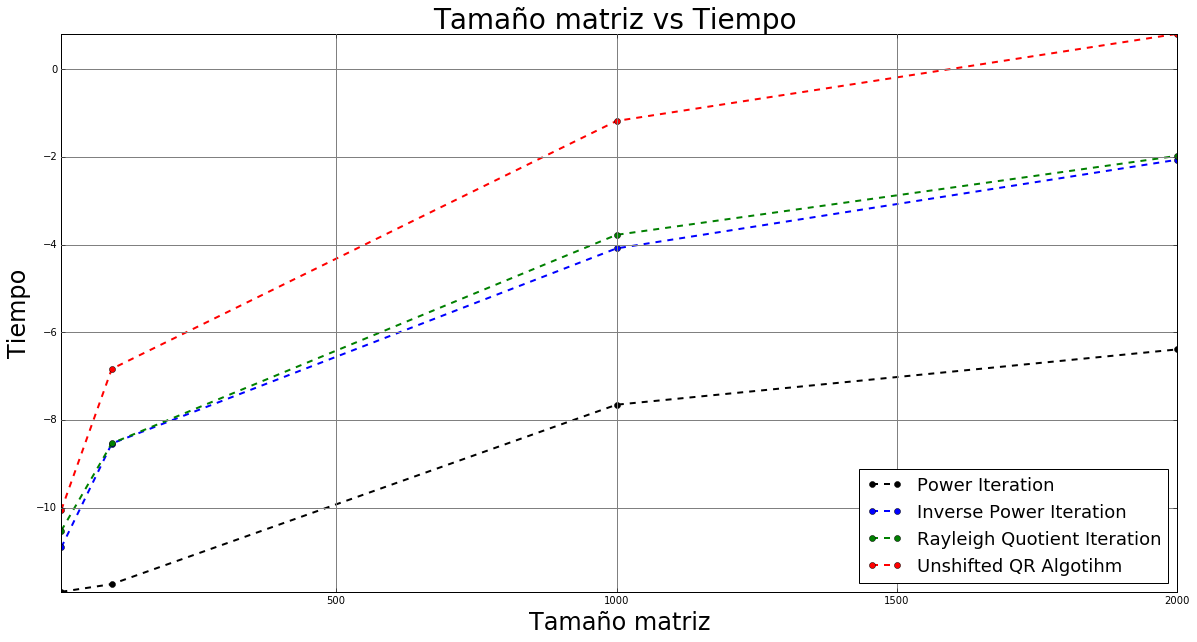

In [32]:
#Se analizan los ordenes de magnitud para que sea mas corto el calculo
size = [10,100,1000,2000]
plt.figure(figsize=(20,10))
plt.plot(size, np.log(PI), '--ko', linewidth = 2, label = 'Power Iteration')
plt.hold(True)
plt.plot(size, np.log(IPI),'--bo', linewidth = 2, label = 'Inverse Power Iteration')
plt.hold(True)
plt.plot(size, np.log(RQI),'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration')
plt.hold(True)
plt.plot(size, np.log(UQR),'--ro', linewidth = 2, label = 'Unshifted QR Algotihm')
plt.legend(loc = 4,prop={'size':18})
plt.xlabel("Tamaño matriz", fontsize = 24)
plt.ylabel("Tiempo", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '-', linewidth = 1)
plt.axis('tight')
plt.title("Tamaño matriz vs Tiempo ",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

<div id='pregunta3' />
## Pregunta 3

Para el calculo del error, primero se inicializan las variables fijas, las cuales seran la tolerancia de error, la cual es $1e-10$ y el valor propio dominante teorico, el cual sabemos cual es ($\frac{1}{2}$, el valor mas grande). La funcion recibe el metodo a usar (1=Power Iteration, 2=Inverse Power Iteration,3=Rayleigh Quotient Iteration y 4=Unshifted QR Algorithm), ademas del tamaño de la matriz, la cual sera usada para crear la matriz y el vector inicial. Posteriormente se se crean 2 arreglos donde se almacenara la iteracion y el error correspondiente a esa iteracion. Luego, se calcula la primera iteracion en el metodo correspondiente. Si casualmente se encuentra el valor propio dominante, no es necesario hacer un ciclo $while$, en caso contrario de procede a hacer iteraciones hasta que la diferencia entre el valor propio dominante y experimental sea menor que la tolerancia, agregando la iteracion y error correspondientes a sus arreglos. Finalmente, se grafican los arreglos correspondientes para las matrices n=10,100,1000,2000.

In [6]:
def calculo_error(metodo,tamaño_matriz):    
    tol = 1e-10
    vp_teorico = (1.0/2.0)
    M = crear_matriz(tamaño_matriz)
    y = np.ones(tamaño_matriz)
    iteracion = 1

    error = []
    iteraciones = []

    if(metodo == 1):
        vp_experimental, u = power_iteration(M, y, 1)
    elif(metodo == 2):
        vp_experimental, u = inverse_power_iteration(M, y, 0.45, 1)
    elif(metodo == 3):
        vp_experimental, u = rqi(M, y, 1)
    elif(metodo == 4):
        vp, u, vp_experimental = unshiftedqr(M,1)
    else:
        print("El metodo ingresado no existe.")

    iteraciones.append(iteracion)
    error.append(abs(vp_teorico - vp_experimental))

    while(abs(vp_teorico - vp_experimental) >= tol):
        iteracion = iteracion+1
        if(metodo == 1):
            vp_experimental, u = power_iteration(M, y, iteracion)
        elif(metodo == 2):
            vp_experimental, u = inverse_power_iteration(M, y, 0.45, iteracion)
        elif(metodo == 3):
            vp_experimental, u = rqi(M, y, iteracion)
        elif(metodo == 4):
            vp, u, vp_experimental = unshiftedqr(M,iteracion)
        else:
            print("El metodo ingresado no existe.")
        if(abs(vp_teorico - vp_experimental) >= tol):
            iteraciones.append(iteracion)
            error.append(abs(vp_teorico - vp_experimental))
    return iteraciones, error

### Para n = 10

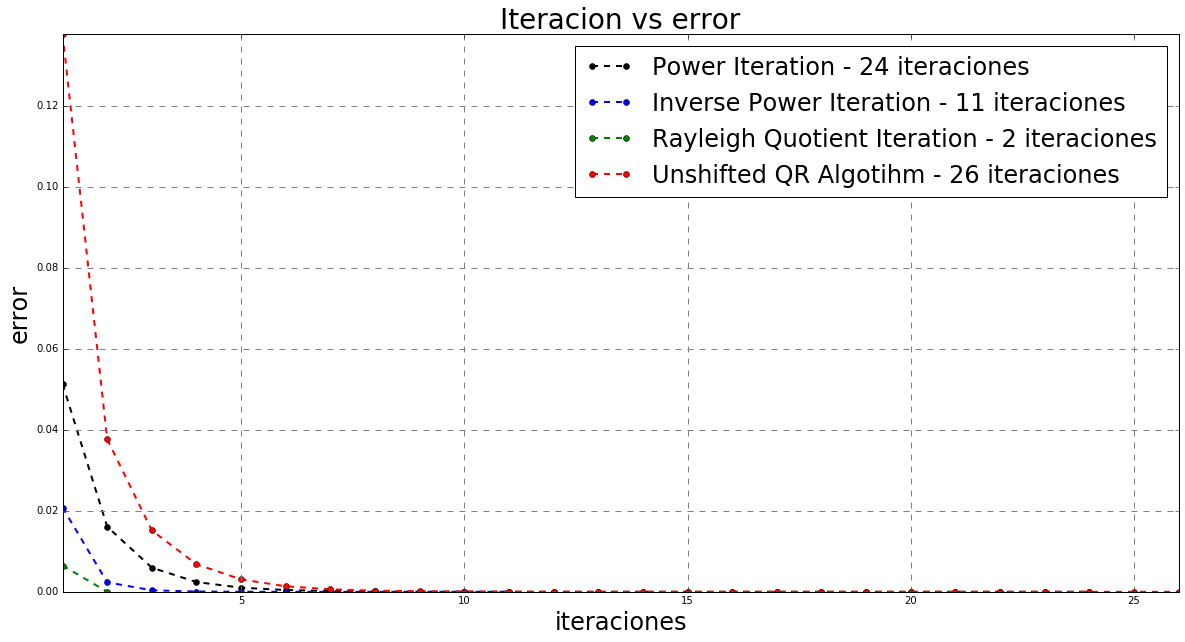

In [7]:
iteraciones_PI,error_PI = calculo_error(1,10)
iteraciones_IPI, error_IPI = calculo_error(2,10)
iteraciones_RQI, error_RQI = calculo_error(3,10)
iteraciones_UQR, error_UQR = calculo_error(4,10)

plt.figure(figsize=(20,10))
plt.plot(iteraciones_PI, error_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.plot(iteraciones_IPI, error_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_RQI, error_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_UQR, error_UQR,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 1,prop={'size':24})
plt.xlabel("iteraciones", fontsize = 24)
plt.ylabel("error", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Iteracion vs error",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Para n = 100

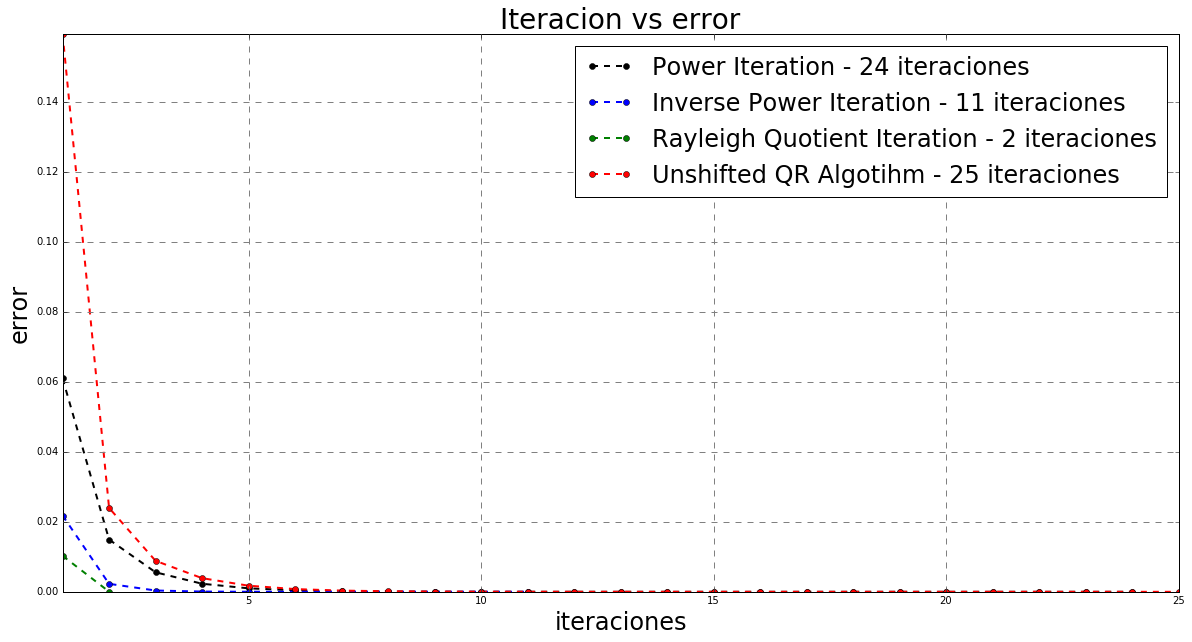

In [19]:
iteraciones_PI,error_PI = calculo_error(1,100)
iteraciones_IPI, error_IPI = calculo_error(2,100)
iteraciones_RQI, error_RQI = calculo_error(3,100)
iteraciones_UQR, error_UQR = calculo_error(4,100)

plt.figure(figsize=(20,10))
plt.plot(iteraciones_PI, error_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.plot(iteraciones_IPI, error_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_RQI, error_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_UQR, error_UQR,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 1,prop={'size':24})
plt.xlabel("iteraciones", fontsize = 24)
plt.ylabel("error", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Iteracion vs error",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Para n = 1000

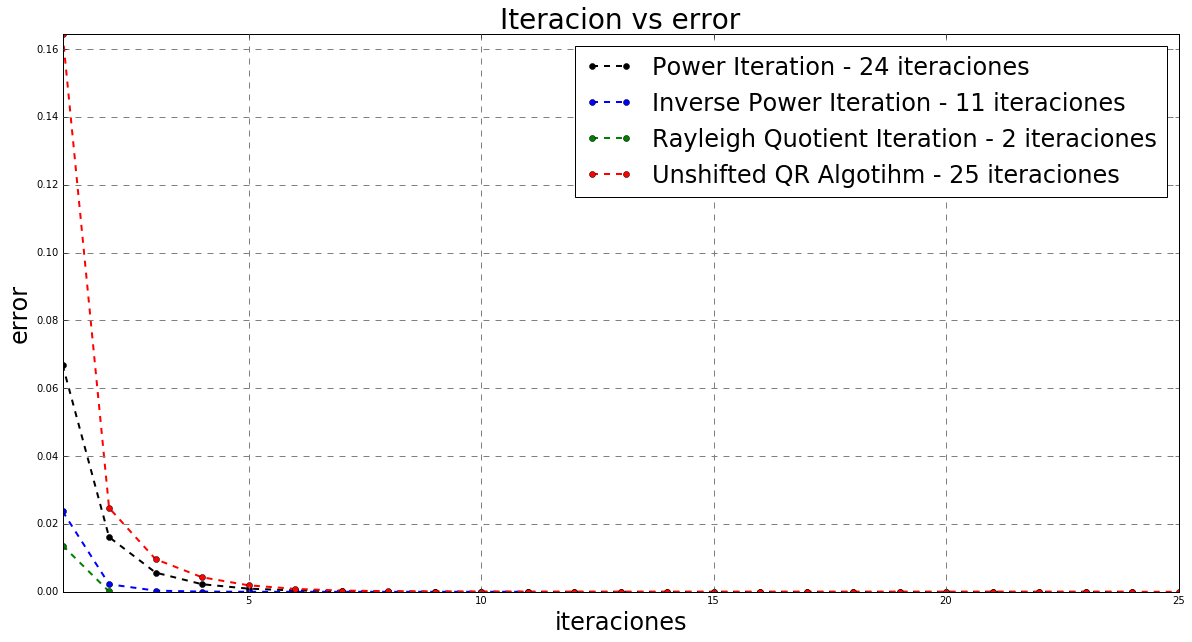

In [46]:
iteraciones_PI,error_PI = calculo_error(1,1000)
iteraciones_IPI, error_IPI = calculo_error(2,1000)
iteraciones_RQI, error_RQI = calculo_error(3,1000)
iteraciones_UQR, error_UQR = calculo_error(4,1000)

plt.figure(figsize=(20,10))
plt.plot(iteraciones_PI, error_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.plot(iteraciones_IPI, error_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_RQI, error_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_UQR, error_UQR,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 1,prop={'size':24})
plt.xlabel("iteraciones", fontsize = 24)
plt.ylabel("error", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Iteracion vs error",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Para n = 2000

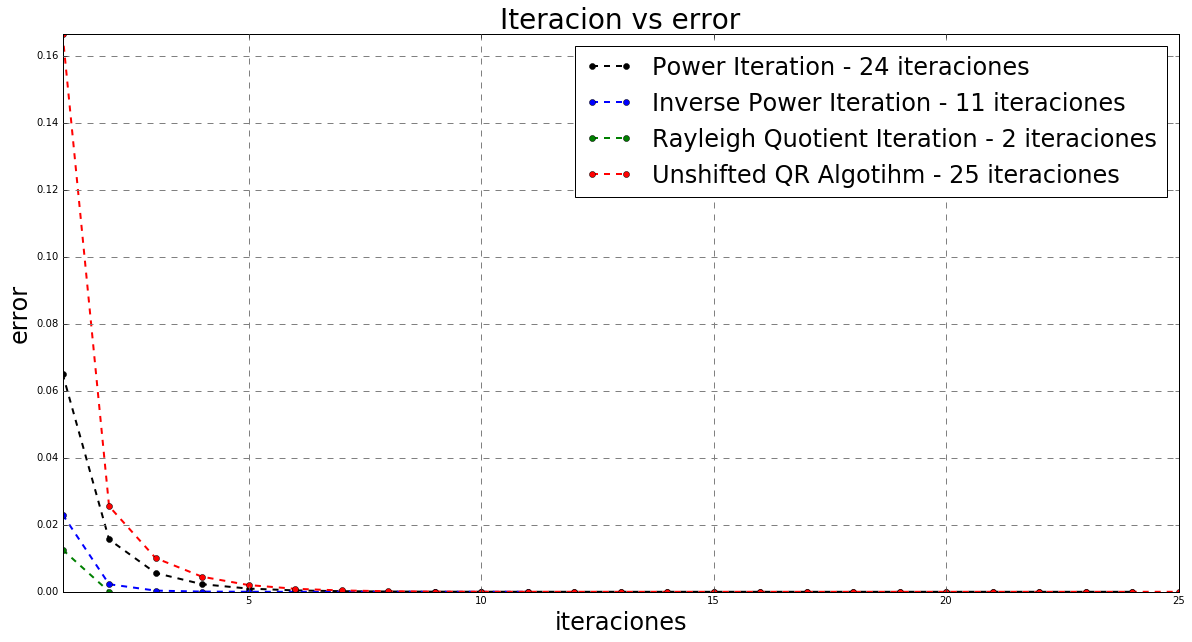

In [47]:
iteraciones_PI,error_PI = calculo_error(1,2000)
iteraciones_IPI, error_IPI = calculo_error(2,2000)
iteraciones_RQI, error_RQI = calculo_error(3,2000)
iteraciones_UQR, error_UQR = calculo_error(4,2000)

plt.figure(figsize=(20,10))
plt.plot(iteraciones_PI, error_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.plot(iteraciones_IPI, error_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_RQI, error_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.plot(iteraciones_UQR, error_UQR,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 1,prop={'size':24})
plt.xlabel("iteraciones", fontsize = 24)
plt.ylabel("error", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Iteracion vs error",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

En los graficos anteriormente mostrados, los algoritmos mostrados convergieron a la tolerancia en 24 a 25 iteraciones para todos los tipos de matrices, excepto el Rayleigh Quotient Iteration.

Podemos observar que el método mas eficiente y que demora menos tiempo e iteraciones es efectivamente Rayleigh Quotient Iteration, puesto que se actualiza con el valor propio real (cabe destacar que dependiendo del vector inicial ingresado en el algoritmo, puede ser mas lento y con mas iteraciones). Posteriormente el mas eficiente es el Inverse Power Iteration, puesto que se le colocó un corrimiento bastante cercano al valor propio dominante, el cual es conocido. Cabe destacar que si el corrimiento es mas lejano al valor propio dominante, mas se demorara en converger el algoritmo. Luego, es el Power Iteration el que le sigue, el cual se demora una cantidad de iteraciones similar al Inverse Power Iteration, debido al corrimiento ingresado, y finalmente es Unshifted QR quien se demora la mayor cantidad de tiempo, y con la mayor cantidad de error por iteración, debido a que este algoritmo encuentra todos los valores propios, siendo el primer valor de la diagonal el dominante, ademas de que la complejidad de Unshifted QR es superior a la de los demas algoritmos.

<div id='pregunta4' />
## Pregunta 4

Para esta pregunta, utilizaremos la misma función que la pregunta 3, recibiendo ademas como parámetro el tiempo promedio que se demora una iteración (calculado en la pregunta 2). Luego, se procedera a mostrar los 4 graficos con tamaños distintos de matrices, para ver como se comporta el error a medida que pasa el tiempo. 

In [12]:
def calculo_error_tiempo(metodo,tamaño_matriz,tiempo):    
    tol = 1e-14
    vp_teorico = (1.0/2.0)
    M = crear_matriz(tamaño_matriz)
    y = np.ones(tamaño_matriz)
    iteracion = 1

    error = []
    iteraciones = []

    if(metodo == 1):
        vp_experimental, u = power_iteration(M, y, 1)
    elif(metodo == 2):
        vp_experimental, u = inverse_power_iteration(M, y, s=0.45, k=1)
    elif(metodo == 3):
        vp_experimental, u = rqi(M, y, 1)
    elif(metodo == 4):
        vp, u, vp_experimental = unshiftedqr(M,1)
    else:
        print("El metodo ingresado no existe.")

    iteraciones.append(iteracion)
    error.append(abs(vp_teorico - vp_experimental))

    while(abs(vp_teorico - vp_experimental) >= tol):
        iteracion = iteracion+1
        if(metodo == 1):
            vp_experimental, u = power_iteration(M, y, iteracion)
        elif(metodo == 2):
            vp_experimental, u = inverse_power_iteration(M, y, 0.45, iteracion)
        elif(metodo == 3):
            vp_experimental, u = rqi(M, y, iteracion)
        elif(metodo == 4):
            vp, u, vp_experimental = unshiftedqr(M,iteracion)
        else:
            print("El metodo ingresado no existe.")
        if(abs(vp_teorico - vp_experimental) >= tol):
            iteraciones.append(iteracion)
            error.append(abs(vp_teorico - vp_experimental))
    
    return np.dot(iteraciones,tiempo), error

### Para n = 10

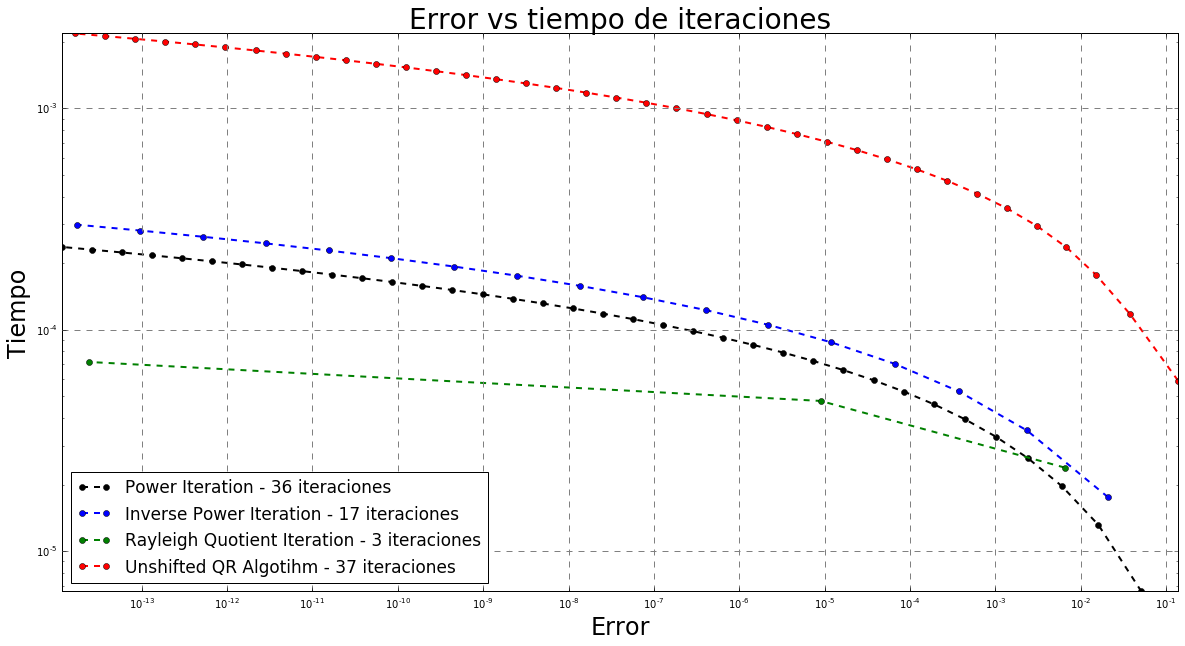

In [13]:
iteraciones_PI,error_PI = calculo_error_tiempo(1,10,PI[0])
iteraciones_IPI, error_IPI = calculo_error_tiempo(2,10,IPI[0])
iteraciones_RQI, error_RQI = calculo_error_tiempo(3,10,RQI[0])
iteraciones_UQR, error_UQR = calculo_error_tiempo(4,10,UQR[0])

plt.figure(figsize=(20,10))
plt.loglog(error_PI,iteraciones_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.loglog(error_IPI, iteraciones_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_RQI, iteraciones_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_UQR, iteraciones_UQR ,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 3,prop={'size':17})
plt.xlabel("Error", fontsize = 24)
plt.ylabel("Tiempo", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Error vs tiempo de iteraciones",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Paran n = 100

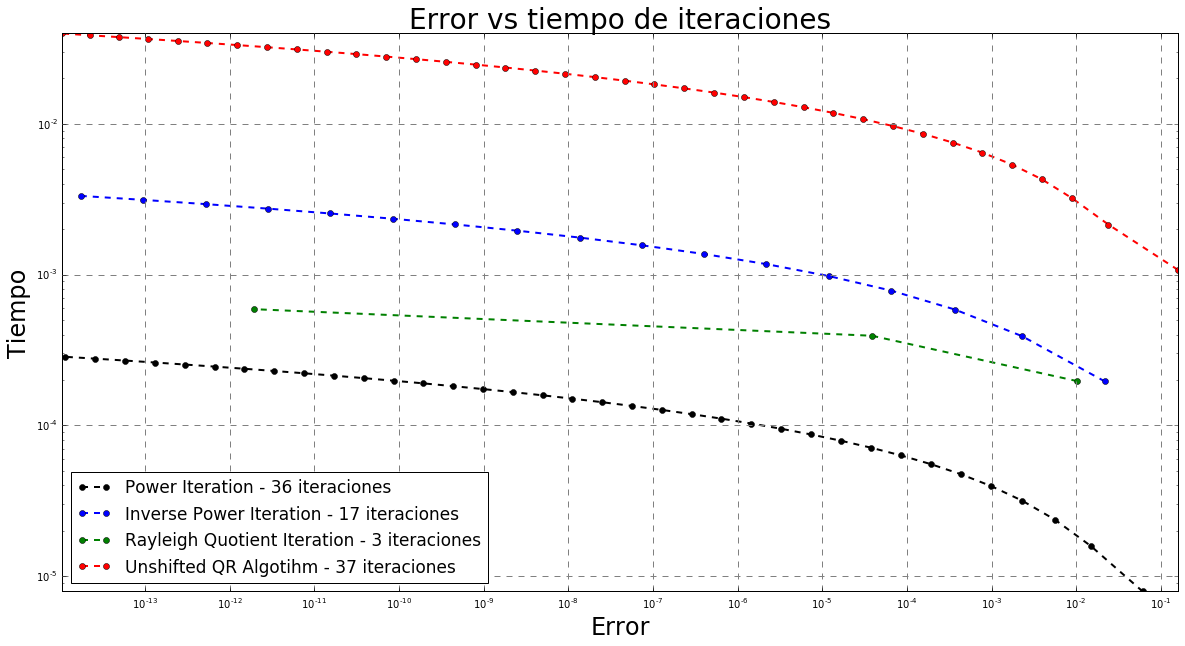

In [77]:
iteraciones_PI,error_PI = calculo_error_tiempo(1,100,PI[1])
iteraciones_IPI, error_IPI = calculo_error_tiempo(2,100,IPI[1])
iteraciones_RQI, error_RQI = calculo_error_tiempo(3,100,RQI[1])
iteraciones_UQR, error_UQR = calculo_error_tiempo(4,100,UQR[1])

plt.figure(figsize=(20,10))
plt.loglog(error_PI,iteraciones_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.loglog(error_IPI, iteraciones_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_RQI, iteraciones_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_UQR, iteraciones_UQR ,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 3,prop={'size':17})
plt.xlabel("Error", fontsize = 24)
plt.ylabel("Tiempo", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Error vs tiempo de iteraciones",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Para n = 1000

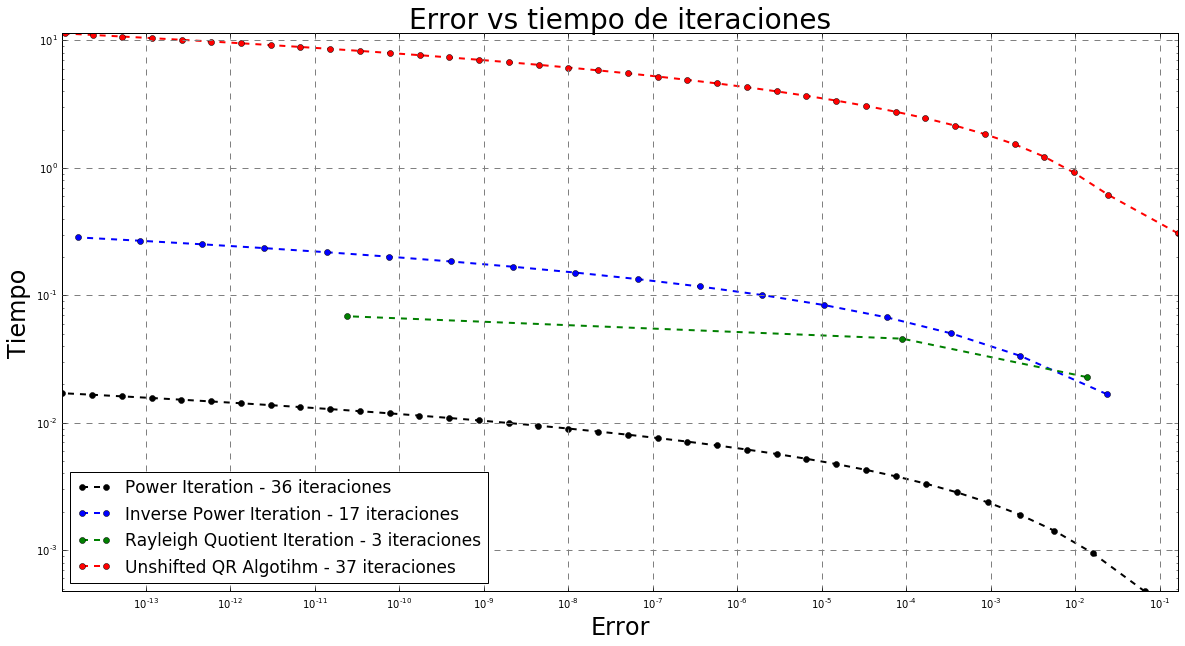

In [78]:
iteraciones_PI,error_PI = calculo_error_tiempo(1,1000,PI[2])
iteraciones_IPI, error_IPI = calculo_error_tiempo(2,1000,IPI[2])
iteraciones_RQI, error_RQI = calculo_error_tiempo(3,1000,RQI[2])
iteraciones_UQR, error_UQR = calculo_error_tiempo(4,1000,UQR[2])

plt.figure(figsize=(20,10))
plt.loglog(error_PI,iteraciones_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.loglog(error_IPI, iteraciones_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_RQI, iteraciones_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_UQR, iteraciones_UQR ,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 3,prop={'size':17})
plt.xlabel("Error", fontsize = 24)
plt.ylabel("Tiempo", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Error vs tiempo de iteraciones",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

### Para n = 2000

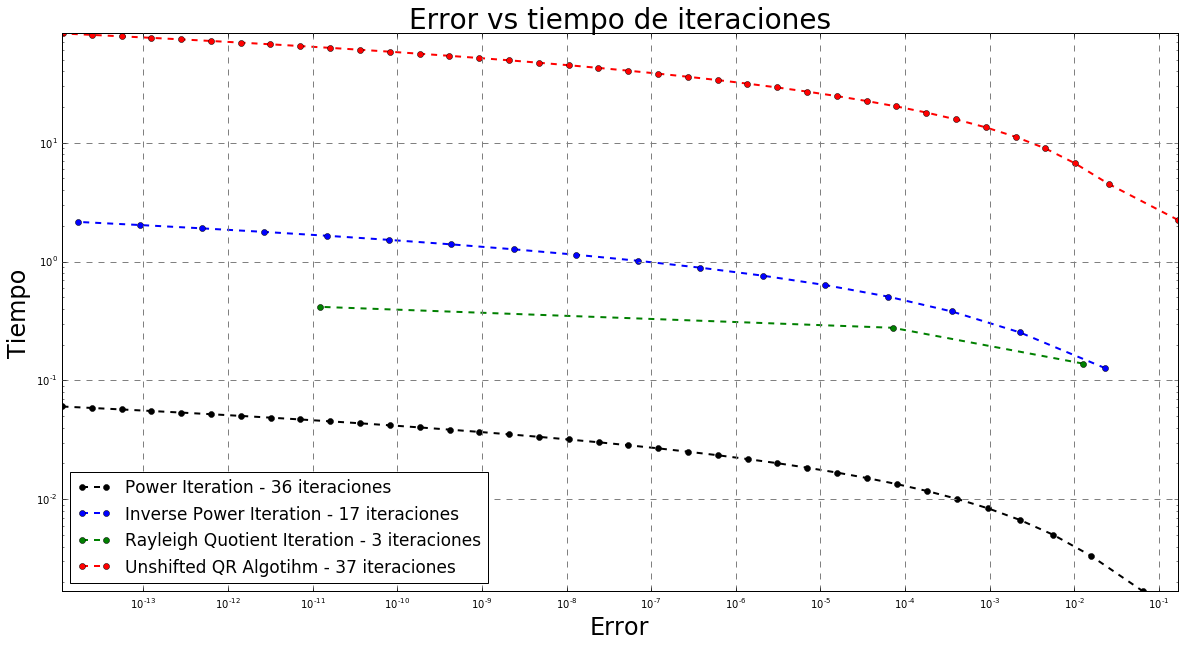

In [79]:
iteraciones_PI,error_PI = calculo_error_tiempo(1,2000,PI[3])
iteraciones_IPI, error_IPI = calculo_error_tiempo(2,2000,IPI[3])
iteraciones_RQI, error_RQI = calculo_error_tiempo(3,2000,RQI[3])
iteraciones_UQR, error_UQR = calculo_error_tiempo(4,2000,UQR[3])

plt.figure(figsize=(20,10))
plt.loglog(error_PI,iteraciones_PI, '--ko', linewidth = 2, label = 'Power Iteration - ' + str(len(iteraciones_PI)) + ' iteraciones' )
plt.hold(True)
plt.loglog(error_IPI, iteraciones_IPI,'--bo', linewidth = 2, label = 'Inverse Power Iteration - ' + str(len(iteraciones_IPI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_RQI, iteraciones_RQI,'--go', linewidth = 2, label = 'Rayleigh Quotient Iteration - '  + str(len(iteraciones_RQI)) + ' iteraciones')
plt.hold(True)
plt.loglog(error_UQR, iteraciones_UQR ,'--ro', linewidth = 2, label = 'Unshifted QR Algotihm - ' + str(len(iteraciones_UQR)) + ' iteraciones')
plt.legend(loc = 3,prop={'size':17})
plt.xlabel("Error", fontsize = 24)
plt.ylabel("Tiempo", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("Error vs tiempo de iteraciones",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

Finalmente luego de todos los experientos realizados, podemos concluir ciertas cosas importantes. Para la obtención de valores propios, tenemos 2 cosas a tener en cuenta: obtener el valor propio dominante, el cual es el que nos entrega la mayor cantidad de información, o la obtención de todos los valores propios. 

Para el segundo caso, Unshifted QR es la mejor alternativa, puesto que si bien es el algoritmo que se demora más tiempo en comparación al resto, este nos entrega todos los valores propios de la matriz, lo cual nos puede ser de mucha utilidad.

Para el primer caso en cambio tenemos 3 opciones para poder obtener el valor propio dominante. Power Iteration, Inverse Power iteration y Rayleigh Quotient iteration. Power Iteration es la mejor opcion para sacar el valor propio si contamos con poco tiempo, puesto que por los experimentos realizados nos damos cuenta de que es el algoritmo que menos se tarda. 

Si contamos con tiempo, dependiendo de las condiciones que se tengan, los 2 algoritmos restantes pueden llegar en menos iteraciones al valor propio dominante. En el caso de Inverse Power Iteration, si tenemos la casualidad de que el corrimiento ingresado en el algormitmo, es cercano al valor propio, el algoritmo convergera en muy poco tiempo, aunque entre mas alejado este el corrimiento, más se demorara. Por otro lado, si el vector inicial ingresado no es mal condicionado, sera Rayleigh Quotient Iteration quien llegue mas rápido y en pocas iteraciones al valor propio buscado, puesto que el algoritmo va acutalizando con el mismo lambda encontrado anteriormente el corrimiento, hasta que la matriz sea singular (lo cual es bueno, ya que quiere decir que encontramos el valor propio que andabamos buscando).

En resumen, cada algoritmo tiene sus ventajas y desventajas, y sera la situación y lo que se busca los factores claves para elegir que algoritmo usar.

<div id='alg' />
# Conclusiones

Con los experimentos realizados en este laboratorio podemos concluir que los 4 metodos son bastante eficientes y cada uno calcula a su forma los valores propios dominantes. Sin embargo, cabe destacar que dependiendo de la situación un algoritmo puede resultar mucho mas eficiente que otro. Por ejemplo, si se coloca un corrimiento muy cercano al valor propio dominante en el Inverse Power Iteration, lo mas probable es que converga mas rápido que los otros métodos. Con esto podemos concluir que un metodo puede ser mas eficiente que otro dependiendo de las variables que se ingresen en el algoritmo.

<div id='ref' />
# Referencias

Documentacion donde se explica la complejidad del metodo "solve" de python:
- http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html


Documentacion de LAPACK _gesv:
- http://www.netlib.org/lapack/lug/node71.html#fig:GELScomparison